In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary
import os, time
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split



In [92]:
#win
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#Mac
# device = torch.device('mps')
device

'cuda:0'

In [93]:
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

numpy dataの読み込み

In [94]:
day1_data = np.load('numpy_data/subject1_data1.npy')
day1_label = np.load('numpy_data/subject1_label1.npy')
day2_data = np.load('numpy_data/subject1_data2.npy')
day2_label = np.load('numpy_data/subject1_label2.npy')

# day1_data2 = np.load('numpy_data/subject2_data1.npy')
# day1_label2 = np.load('numpy_data/subject2_label1.npy')
# day2_data2 = np.load('numpy_data/subject2_data2.npy')
# day2_label2 = np.load('numpy_data/subject2_label2.npy')

# day1_data3 = np.load('numpy_data/subject3_data1.npy')
# day1_label3 = np.load('numpy_data/subject3_label1.npy')
# day2_data3 = np.load('numpy_data/subject3_data2.npy')
# day2_label3 = np.load('numpy_data/subject3_label2.npy')

データの結合

In [95]:
brain_data = np.vstack([day1_data,day2_data])
label_data = np.hstack([day1_label,day2_label])
# brain_data = np.vstack([day1_data,day2_data,day1_data2,day2_data2,day1_data3,day2_data3])
# label_data = np.hstack([day1_label,day2_label,day1_label2,day2_label2,day1_label2,day2_label2])
# info_motorbrain = ['FC3','FC1','C1','C3','C5','CP3','CP1','CPz','FC4','FC2',
# 'FCz','Cz','C2','C4','C6','CP4','CP2',]
# info_motor = mne.create_info(ch_names=info_motorbrain, ch_types="eeg", sfreq=1024)
# info_motor.set_montage('standard_1020')

In [96]:
#運動野領域のデータ　sampling rate は1024->100 Hz タスクは4秒間
motor_brainAdress = [9,10,11,12,13,17,18,31,44,45,46,47,48,49,50,54,55]
data_numpy_task  = brain_data[:,:,100*6:100*10]

In [97]:
print("brain_data",np.shape(data_numpy_task))
print("label",np.shape(label_data))
label_data = label_data -1

brain_data (240, 64, 400)
label (240,)


In [98]:
#train testの分割
X_train, X_test, Y_train, Y_test = train_test_split(data_numpy_task,label_data, test_size=0.15,random_state=42)
print(np.shape(X_train))

(204, 64, 400)


In [99]:
x_train = torch.from_numpy(np.expand_dims(X_train, axis=1))
X_test = torch.from_numpy(np.expand_dims(X_test, axis=1))
label = torch.tensor(Y_train)
label2 = torch.tensor(Y_test)



In [100]:
print(x_train.shape, label.shape)
print(X_test.shape, label2.shape)

torch.Size([204, 1, 64, 400]) torch.Size([204])
torch.Size([36, 1, 64, 400]) torch.Size([36])


In [101]:
# Datasetを作成
Dataset = torch.utils.data.TensorDataset(x_train, label)
# Datasetを作成
tast_data = torch.utils.data.TensorDataset(X_test, label2)

In [102]:
BATCH_SIZE = 32
Learning_Rate = 0.001
EPOCHS = 1000

In [103]:
trainloader = DataLoader(dataset=Dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=tast_data, batch_size=BATCH_SIZE, shuffle=True)

In [104]:
# EEGNet using Pytorch
class EEGNet(nn.Module):
    def __init__(self, AF=nn.ELU(alpha=1)):
        super(EEGNet, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, 1e-05)
        )      
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, 1e-05),
            AF,
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, 1e-05),
            AF,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=24192, out_features=2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classify(x.view(len(x), -1))
        return x    
EEGNet()

EEGNet(
  (firstConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=24192, out_features=2, bias=True)
  )
)

In [105]:
class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=lr)
        
    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, only_print_finish_ep_num=False):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if (not (ep % 10)) or (ep == 1):
                if not only_print_finish_ep_num:
                    print(f"Epoch {ep}/{epochs}")
            self.model.train()       # Train mode
            step = 1                 # Restart step
            for x_batch, y_batch in trainloader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                pred = self.model(x_batch)
                loss = self.losses(pred, y_batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                if (not (ep % 10)) or (ep == 1):
                    pbar = int(step * 30 / len(trainloader))
                    if not only_print_finish_ep_num:
                        print("\r{}/{} [{}{}]".format(
                            step, len(trainloader), ">" * pbar, " " * (30 - pbar)), 
                            end="")
                step += 1
            loss, acc = self.evaluate(trainloader)   # Loss & Accuracy
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)   # if have validation dataset, evaluate validation
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # Update checkpoint
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                save_file_name = f"checkpoint_model_ep-{ep}.pt"
                self.save("./data/"+save_file_name)
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
                history['lastest_model_path'] = save_file_name
                
            if only_print_finish_ep_num and (ep % 50 == 0):
                print(f"{ep} ", end=" ")
        return history
    
    def evaluate(self, dataloader):
        total, acc = 0, 0
        self.model.eval()           # Eval mode
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch)
            loss = self.losses(pred, y_batch).item()
            total += y_batch.shape[0]     # Number of data
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()     # Sum the prediction that's correct
        acc /= total     # Accuracy = correct prediction / number of data
        return (loss, acc)
    
    def predict(self, dataset):
        dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
        prediction = []
        truth = []
        self.model.eval()
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            pred = self.model(x_batch).cpu()
            prediction = np.append(prediction, pred.argmax(dim=1).numpy())
            truth = np.append(truth, y_batch.cpu().numpy())            
        return prediction, truth
    
    def save(self, filepath):
        torch.save(self.model, filepath)
        
    #@classmethod
    def load(cls, filepath):
        return cls(torch.load(filepath))
    
    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] <= evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] >= evaluation[1]:
                    return False # present epoch acc <= history acc
                elif _ == "val_loss" and pre_ck_point[2] <= evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] >= evaluation[3]:
                    return False # present epoch val_acc < history val_acc        
        return True

In [106]:
eegnet = EEGNet().to(device)
summary(eegnet, (1, 64, 400))
model = Model(eegnet, lr=Learning_Rate)
history = model.fit(trainloader=trainloader, validloader=testloader, epochs=EPOCHS, monitor=["acc", "val_acc"])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 400]             816
       BatchNorm2d-2          [-1, 16, 64, 400]              32
            Conv2d-3          [-1, 32, 63, 400]              64
       BatchNorm2d-4          [-1, 32, 63, 400]              64
               ELU-5          [-1, 32, 63, 400]               0
               ELU-6          [-1, 32, 63, 400]               0
         AvgPool2d-7          [-1, 32, 63, 100]               0
           Dropout-8          [-1, 32, 63, 100]               0
            Conv2d-9          [-1, 32, 63, 100]          15,360
      BatchNorm2d-10          [-1, 32, 63, 100]              64
              ELU-11          [-1, 32, 63, 100]               0
              ELU-12          [-1, 32, 63, 100]               0
        AvgPool2d-13           [-1, 32, 63, 12]               0
          Dropout-14           [-1, 32,

7/7 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]

In [107]:
def plot_acc_and_loss(history, figsize=(10,4), base_save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    if base_save_path:
        st = fig.suptitle(base_save_path, fontsize="x-large")
    
    ax1.title.set_text("Acc")
    ax1.set_xlabel("Epochs")
    l1 = ax1.plot(history["acc"], color="red", label='train')
    l2 = ax1.plot(history["val_acc"], color="blue", label='test')
    
    ax2.title.set_text("Loss")
    ax2.set_ylabel("Epochs")
    l3 = ax2.plot(history["loss"], color="red", label='train')
    l4 = ax2.plot(history["val_loss"], color="blue", label='test')

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")

    plt.show()

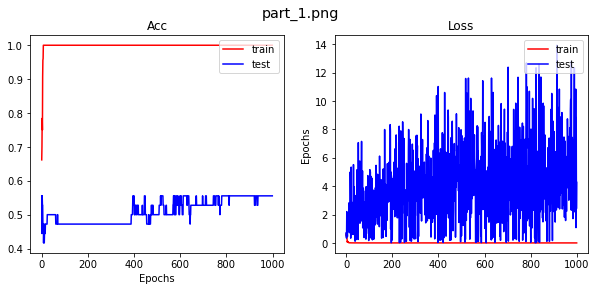

In [108]:
plot_acc_and_loss(history=history, base_save_path="part_1.png")
